# Predicting used car prices in the UK market
_Author: Kostas Batsis_ <br>
_Date: 21/12/2020_

### Introduction

This project concerns the construction of a linear regression model for the prediction of used car prices in the UK market. It is based on datasets of 99,187 scraped used car listings, split into car brand, [recovered from kaggle](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes/tasks?taskId=1258). These include variables on model, prices, mileage, miles per gallon, engine size, year of production, transmission type, fuel type and two tax-related variables. I merged the sets into a single dataset and I dropped the tax variables based on an a-priori judgement of them playing no important role in predicting a car price. Price will serve as the dependent variable and the remaining variables will serve as the independent variables. The analysis was performed with Anaconda Python 3.8.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import mean,std
from sklearn import linear_model
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [2]:
carData = pd.DataFrame()
dirEntries = os.listdir('cardata_kaggle')
for entry in dirEntries:
        currentFrame = pd.read_csv('cardata_kaggle/'+entry)
        carData = carData.append(currentFrame,ignore_index=True)
print(carData.head(5),'\n')
print('Total sample size:',len(carData))
carData = carData.drop('tax',axis=1)
carData = carData.drop('tax(£)',axis=1)

  model  year  price transmission  mileage fuelType    tax   mpg  engineSize  \
0    A1  2017  12500       Manual    15735   Petrol  150.0  55.4         1.4   
1    A6  2016  16500    Automatic    36203   Diesel   20.0  64.2         2.0   
2    A1  2016  11000       Manual    29946   Petrol   30.0  55.4         1.4   
3    A4  2017  16800    Automatic    25952   Diesel  145.0  67.3         2.0   
4    A3  2019  17300       Manual     1998   Petrol  145.0  49.6         1.0   

   tax(£)  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN   

Total sample size: 99187


### Exploratory Data Analysis

I first searched for missing data of which there were none.

In [3]:
print(carData.isnull().sum(),'\n')

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
dtype: int64 



Then I created the dummy variables for each categorical variable in the dataset, I did not drop any categories since I am later going to apply Lasso regression and I wanted to avoid bias. Counts are presented below for each of these variables before the transformation. Note that the other transmission type category as well as the electric car category have very low counts (9 and 6 respectively). For the model variable I printed only counts with a values below 10, we see that relatively few car models have very low counts.

In [4]:
modelValues = carData['model'].value_counts()
print(modelValues[modelValues<10],'\n')
dummy = pd.get_dummies(carData['model'],drop_first=False)
carData = pd.concat([carData,dummy],axis=1)
print(carData['transmission'].value_counts(),'\n')
dummy = pd.get_dummies(carData['transmission'],drop_first=False)
carData = pd.concat([carData,dummy],axis=1)
print(carData['fuelType'].value_counts(),'\n')
dummy = pd.get_dummies(carData['fuelType'],drop_first=False)
carData = pd.concat([carData,dummy],axis=1)

 Caddy Life         8
 M6                 8
 IQ                 8
 SQ7                8
 Z3                 7
 CLK                7
 Eos                7
 Getz               6
 Caddy              6
 Caddy Maxi         4
 Cascada            4
 S8                 4
 Urban Cruiser      4
 Vectra             4
 Fox                4
 S5                 3
 Verso-S            3
 Tigra              3
 Kadjar             3
 Veloster           3
 Ampera             3
 CLC Class          3
 Streetka           2
 R Class            2
 Terracan           2
230                 1
220                 1
180                 1
 Amica              1
 Accent             1
 Escort             1
 Transit Tourneo    1
 Ranger             1
 RS7                1
 A2                 1
200                 1
Name: model, dtype: int64 

Manual       56445
Semi-Auto    22677
Automatic    20056
Other            9
Name: transmission, dtype: int64 

Petrol      54928
Diesel      40928
Hybrid       3078
Other         2

I proceeded with exploring the numerical variables. Histrograms are presented for each.

Text(0.5, 1.0, 'Miles per gallon')

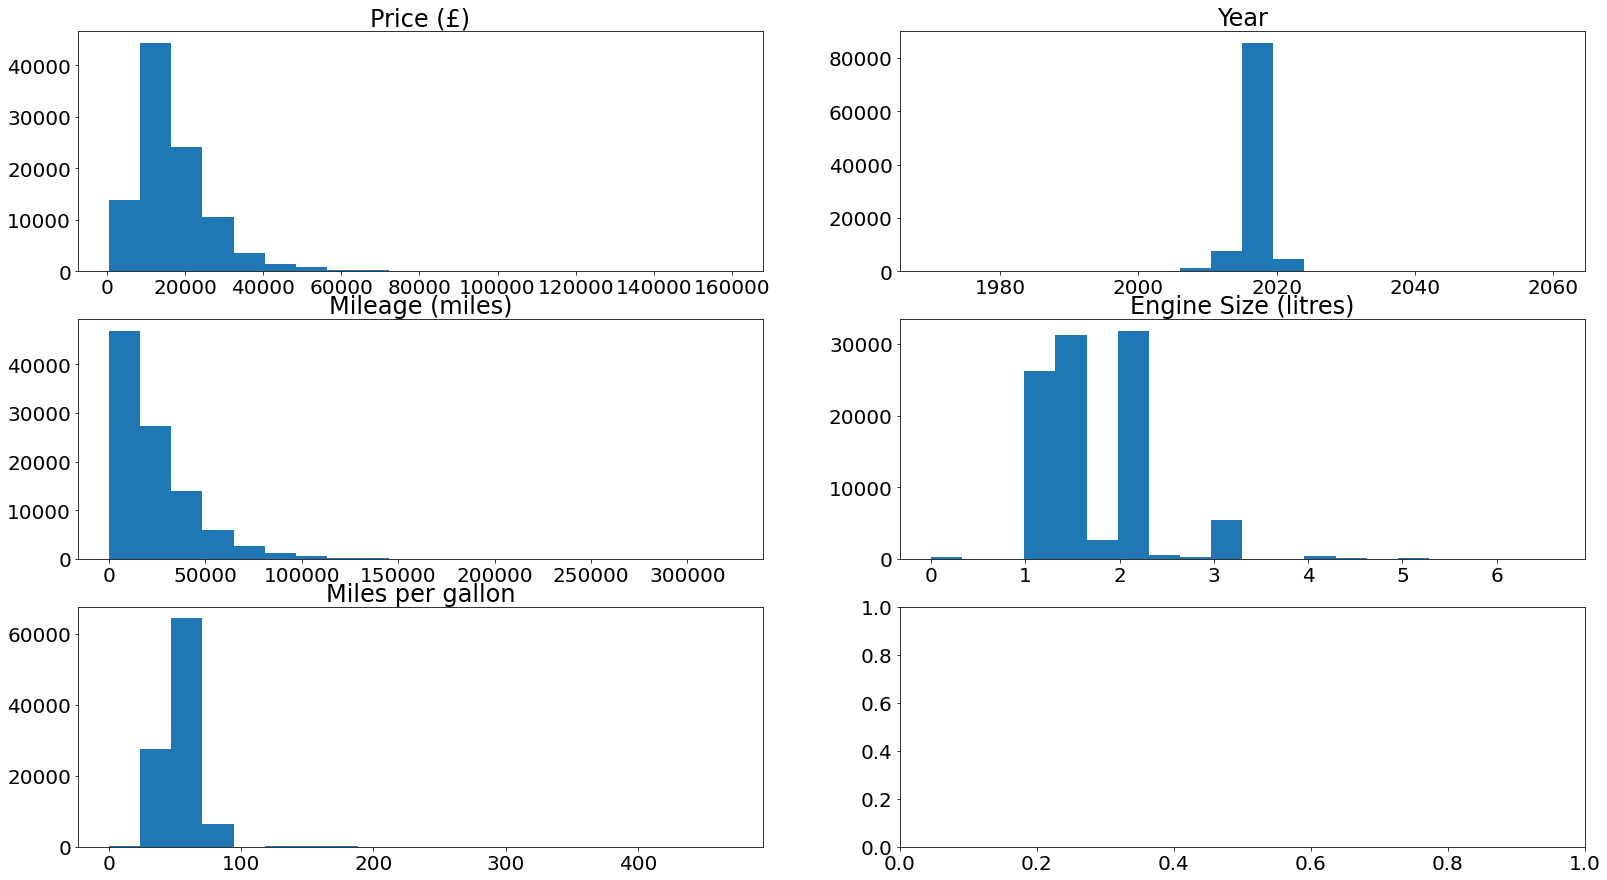

In [5]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(3,2,figsize=(27,15))
axs[0,0].hist(carData['price'],bins=20)
axs[0,0].set_title('Price (£)')
axs[0,1].hist(carData['year'],bins=20)
axs[0,1].set_title('Year')
axs[1,0].hist(carData['mileage'],bins=20)
axs[1,0].set_title('Mileage (miles)')
axs[1,1].hist(carData['engineSize'],bins=20)
axs[1,1].set_title('Engine Size (litres)')
axs[2,0].hist(carData['mpg'],bins=20)
axs[2,0].set_title('Miles per gallon')

All variables except for year have a positive skew. Year includes a non-sensical value of 2060 which I removed. Engine size also includes 273 illogical values of zero. An examinantion of these data revealed no obvious patterns (see below for a sample). Most of these cases concern cars which burn conventional fuels and therefore should have non-zero engine sizes, with the possible exception of two electric cars and one car belonging to the other category. I removed all cases where engine size equaled zero and since the sample size of electric cars is small (n=6) and engine size has no direct meaning for these cars I excluded this category from my analysis.

In [6]:
carData = carData.drop(index=carData[carData['year']==2060].index) 
pd.set_option("display.max_rows", 300)
zeroEngSample = carData[carData['engineSize']==0.0]
print('Total zero engine size cases: ',len(zeroEngSample),'\n')
zeroEngPrintOut = zeroEngSample.iloc[:,0:8]
zeroEngPrintOut = zeroEngPrintOut.drop('engineSize',axis=1)
print(zeroEngPrintOut.sample(30))

Total zero engine size cases:  273 

           model  year  price transmission  mileage fuelType    mpg
95678     Tiguan  2016  15300       Manual    38398   Diesel   53.3
14879         i3  2015  15498    Automatic    33931   Hybrid  470.8
83492   Insignia  2017  14000       Manual     8725   Petrol   47.1
37784        Ka+  2019   9999       Manual    10000   Petrol   47.9
39447        I30  2017  10500    Automatic    17663   Diesel   72.4
39468       I800  2018  15500       Manual    30305   Diesel   31.7
83502   Insignia  2018  15500       Manual    17733   Petrol   46.3
7749          Q3  2020  29488       Manual     1500   Petrol   40.9
56346    M Class  1970  24999    Automatic    14000   Diesel   39.2
7662          Q2  2020  24990       Manual     1500   Petrol   43.5
19378   1 Series  2016  12400       Manual    24528   Diesel   68.9
13945         i3  2016  16482    Automatic    43695   Hybrid  470.8
37786      Focus  2017  12975       Manual    11000   Petrol   51.4
7506       

In [7]:
print('\n',carData[carData['engineSize']==0.0].fuelType.value_counts(),'\n')
carData = carData.drop(carData[carData['engineSize']==0.0].index,axis=0)
carData = carData.drop('Electric',axis=1)


 Petrol      163
Diesel       69
Hybrid       38
Electric      2
Other         1
Name: fuelType, dtype: int64 



Histograms of the two modified variables follow. Year has now a negative skew.

Text(0.5, 1.0, 'Engine Size (litres)')

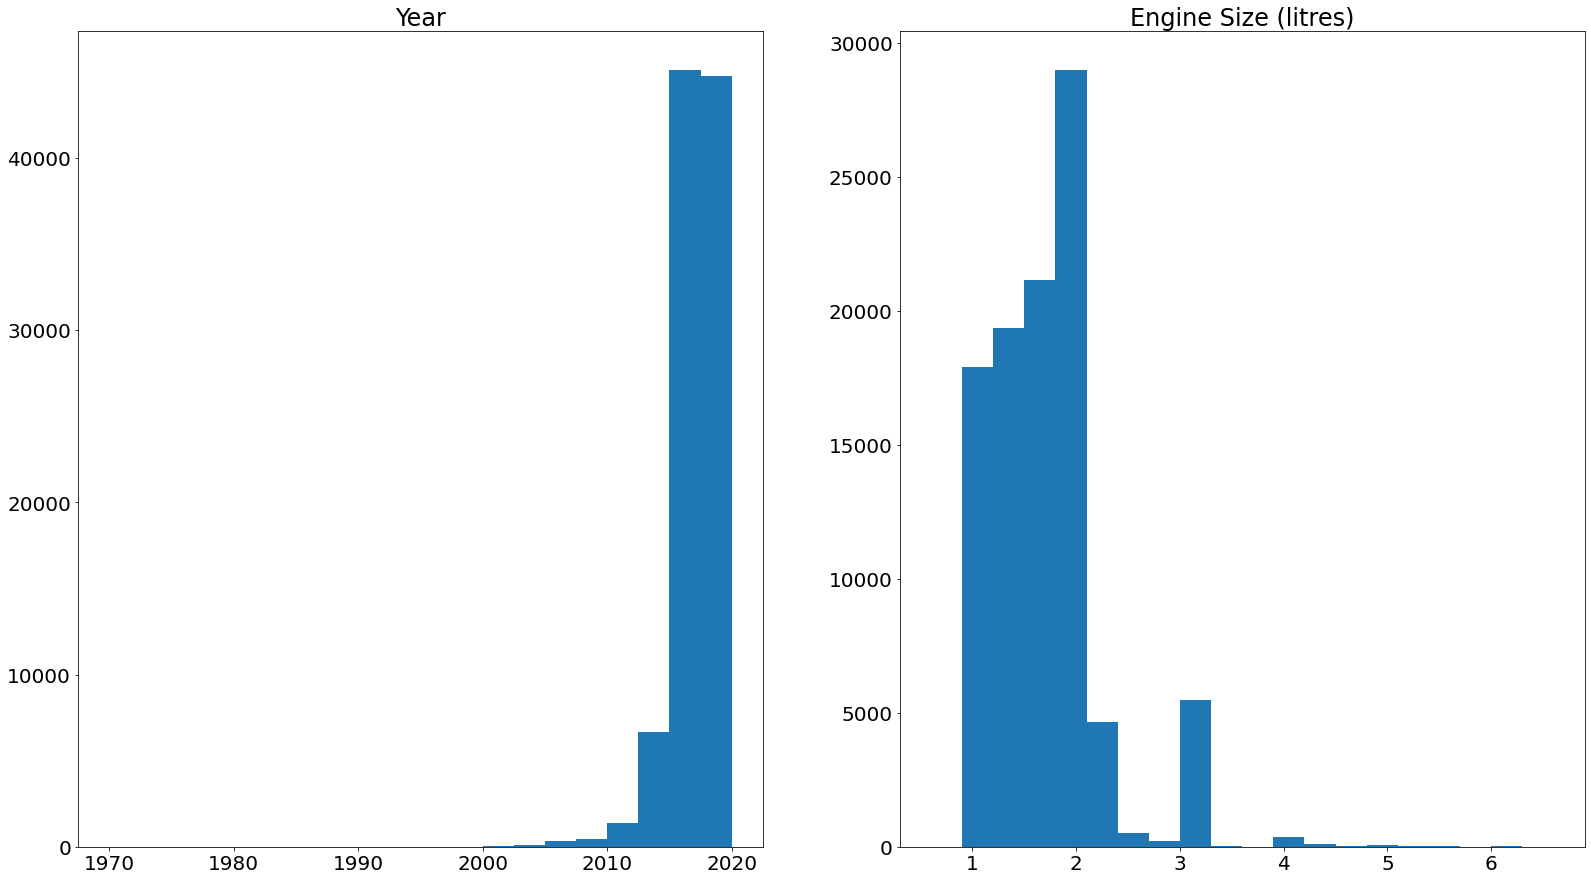

In [8]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1,2,figsize=(27,15))
axs[0].hist(carData['year'],bins=20)
axs[0].set_title('Year')
axs[1].hist(carData['engineSize'],bins=20)
axs[1].set_title('Engine Size (litres)')

To examine for multivariate outliers among the numerical IVs I used the Mahalanobis distance. The distances of the cases ranged from 0.07 to about 2,512 so I chose to examine cases with a distance greater than 500 for any abnormalities. These data are presented below and all values look normal. The largest distance concerns a very old car dating from 1970. I proceeded with the conclusion of no problems with multivariate outliers being present.

In [9]:
robustCov = MinCovDet().fit(carData[['year','mileage','mpg','engineSize']])
maha = robustCov.mahalanobis(carData[['year','mileage','mpg','engineSize']])
print('Mahalanobis min:',maha.min(),'Mahalanobis max:',maha.max())
carData['mahalanobis'] = maha
mahaOutliers = carData[carData['mahalanobis']>500]
print('\n',mahaOutliers[['year','mileage','mpg','engineSize','mahalanobis']])

Mahalanobis min: 0.07126073019694673 Mahalanobis max: 2512.2801392025813

        year  mileage    mpg  engineSize  mahalanobis
9822   2008   323000   44.1         2.0  1147.034400
10700  2016    25269  470.8         0.6  1879.960180
18856  2015    59000  470.8         0.6  1829.219559
19288  2017    32867  470.8         0.6  1886.975237
19503  2015    29465  470.8         1.0  1879.524297
20293  1996    36000   26.4         2.8   513.652969
20748  2017    19178  470.8         0.6  1904.091513
20754  2017    23956  470.8         0.6  1897.368450
20993  2016    41063  470.8         0.6  1860.819153
21198  2017    50867  470.8         0.6  1874.500442
55618  2010   259000   30.7         3.0   734.144055
57178  2016   240494   68.9         2.1   795.623433
62978  2010   250650   57.6         1.9   648.356763
63462  2010   300000   57.6         1.9  1016.542996
63485  2009   241565   47.9         1.9   572.305080
81217  2013   279000   55.4         1.7   978.176505
81235  1970    37357   4

Then I created the IV matrix and the DV vector.

In [10]:
xSet = carData.drop(['price','transmission','model','fuelType','mahalanobis'],axis=1)
ySet = carData['price']

Since multicollinearity does not influence the predictions, the precision of the predictions and the goodness-of-fit statistics I proceeded without any related diagnostics. Next I fitted a regression equation to the data with the sole purpose of examining residual plots and checking the linear regression assumptions. The plot is presented below and I observed important problems with heteroscedasticity and non-linearity. I also observed an outlier in the solution which turned out to be the 1970 car with the highest Mahalanobis distance. I removed this outlier. Then I performed a natural logarithm transformation of the dependent variable (price).

I fitted the equation again and the results are shown in the second residual plot below. Now the assumptions of linearity, homoscedasticity and normality are met to a reasonable degree.

Text(0, 0.5, 'Residuals')

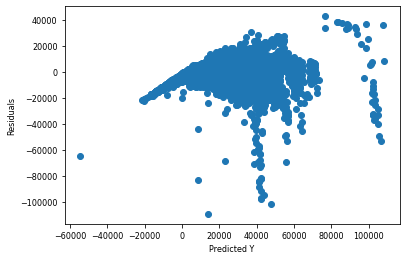

In [11]:
residualsModel = linear_model.LinearRegression() 
residualsModel.fit(xSet,ySet)
fig = plt.figure()
plt.rcParams.update({'font.size': 8})
predictedValues = residualsModel.predict(xSet)
plt.scatter(predictedValues,predictedValues-ySet,label='Residual Plot') 
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')

Outlier data:
        year  mileage   mpg  engineSize
81235  1970    37357  42.2         1.4


Text(0, 0.5, 'Residuals')

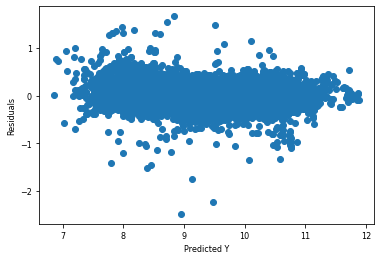

In [12]:
predY = residualsModel.predict(xSet)
outIndex = np.where(predY==predY.min())
outIndex = outIndex[0]
print('Outlier data:\n',xSet.iloc[outIndex,0:4])
outIndex = xSet[xSet['year']==1970].index
xSet = xSet.drop(index=outIndex)
ySet = ySet.drop(index=outIndex)
ySet = np.log(ySet)
residualsModel = linear_model.LinearRegression(fit_intercept=True) 
residualsModel.fit(xSet,ySet)
fig = plt.figure()
predictedValues = residualsModel.predict(xSet)
plt.scatter(predictedValues,predictedValues-ySet,label='Residual Plot') 
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')

I also ran a Durbin-Watson test whose value of 1.74 indicates a lack of problems with non-independence of errors.

In [13]:
print('\nDurbin-Watson:',durbin_watson(predictedValues-ySet))


Durbin-Watson: 1.7386372149115887


### Regression Modeling

For the modeling part I built a Lasso regression with 10-fold cross-validation. To meet the Lasso assumptions I standardized the numerical IVs and centered the DV, seperately in each fold. I implemented the regression with scikit-learn's LassoCV method which performs automatic tuning of the Lasso hyperparameter. Mean absolute error (in the original units) is presented below. I obtained a moderate-to-low mean MAE (-0.095, sd: 0.001) which indicates the predictive value of the model.

In [14]:
preprocessor = ColumnTransformer(
    [
        ('scaler',StandardScaler(),['year','mileage','engineSize','mpg'])
    ],
    remainder = 'passthrough'
)

lfolds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
pipeline = Pipeline(steps=[('scaler',preprocessor), ('lasso', LassoCV(alphas=np.arange(0, 1, 0.01),cv=lfolds))])
model = TransformedTargetRegressor(regressor=pipeline,transformer=StandardScaler(with_std=False))

cv = KFold(n_splits=10,random_state=1,shuffle=True)
lresults = cross_validate(model,xSet,ySet,scoring=('neg_mean_absolute_error'),cv=cv,n_jobs=-1)

print('MAE: %.3f (%.3f)' % (mean(lresults['test_score']),std(lresults['test_score'])))

MAE: -0.095 (0.001)
